COHORT means a group of persons sharing a particular statistical or demographic characteristic e.g. the cohort of all children born in 1980. You can quickly glance through this article to get an idea https://corporatefinanceinstitute.com/resources/knowledge/other/cohort-analysis/




The aim of this analysis is to get the retention rates after each month.

Import Libraries

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import datetime as dt
import missingno as mssno 
from textwrap import wrap  

Data Loading and cleaning

In [2]:
data = pd.read_csv('data.csv')
data.head()

'''
For our analysis, we would mainly be working with the following columns; 'customer_id', 'transaction_date'
'''

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,25-02-17,False,Approved,Solex,Standard,medium,medium,71.49,$53.62,41245.0
1,2,3,3120,21-05-17,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,$388.92,41701.0
2,3,37,402,16-10-17,False,Approved,OHM Cycles,Standard,low,medium,1793.43,$248.82,36361.0
3,4,88,3135,31-08-17,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,$381.10,36145.0
4,5,78,787,01-10-17,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,42226.0


In [3]:
data.shape

(20000, 13)

Checking and working with missing values

In [4]:
data.isnull().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [6]:
#fill integer missing values
#replace the ' 's with NaN
data = data.replace(' ', np.NaN)

#impute the integer missing values with mean imputation
data = data.fillna(data.mean())

#count the number of NaNs in the dataset to verify
print(data.isnull().sum())

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order                 0
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date      0
dtype: int64


In [7]:
#confirm that only OBJECT types have missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           20000 non-null  int64  
 1   product_id               20000 non-null  int64  
 2   customer_id              20000 non-null  int64  
 3   transaction_date         20000 non-null  object 
 4   online_order             20000 non-null  object 
 5   order_status             20000 non-null  object 
 6   brand                    19803 non-null  object 
 7   product_line             19803 non-null  object 
 8   product_class            19803 non-null  object 
 9   product_size             19803 non-null  object 
 10  list_price               20000 non-null  float64
 11  standard_cost            19803 non-null  object 
 12  product_first_sold_date  20000 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 2.0+ MB


In [8]:
#fill up the missing values in the OBJECT types
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].value_counts().index[0])

#once again, check for null values
data.isnull().sum()

transaction_id             0
product_id                 0
customer_id                0
transaction_date           0
online_order               0
order_status               0
brand                      0
product_line               0
product_class              0
product_size               0
list_price                 0
standard_cost              0
product_first_sold_date    0
dtype: int64

Assign the Cohorts and Calculate the monthly offset

In [12]:
#convert the 'transaction_date' column to datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

#function to get the first date of each 'transaction_date month'
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

#first day of the month of each transaction
data['TransactionMonth'] = data['transaction_date'].apply(get_month)

#Group by 'customer_id' and select the TransactionMonth
grouping = data.groupby('customer_id')['TransactionMonth']

#use the min() function to assign the smallest transaction date in month value to each customer. 
data['CohortMonth'] = grouping.transform('min')

#view the data again
data.head()


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,TransactionMonth,CohortMonth
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,$53.62,41245.0,2017-02-01,2017-02-01
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,$388.92,41701.0,2017-05-01,2017-01-01
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,$248.82,36361.0,2017-10-01,2017-01-01
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,$381.10,36145.0,2017-08-01,2017-02-01
4,5,78,787,2017-01-10,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,42226.0,2017-01-01,2017-01-01


Calculate time offset in Month as Cohort Index.

In [16]:
#function to get each date integer value
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

#get each date from the 'TransactionMonth' column
trans_year, trans_month, _ = get_date_int(data, 'TransactionMonth')

#get each date from the 'CohortMonth' column
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

In [29]:
#get the difference in years and month
years_diff = trans_year - cohort_year #this wouuld return zeros
months_diff = trans_month - cohort_month

'''
The 'CohortIndex' value is the difference between the first month of transaction and the transaction month. We would later group these numbers to get a good idea of how long (in months) most customers made their first purchase.
'''
#add +1 to the 'month_difference' as the value ranges from 0-11
data['CohortIndex'] = months_diff + 1
data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,TransactionMonth,CohortMonth,CohortIndex
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,$53.62,41245.0,2017-02-01,2017-02-01,1
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,$388.92,41701.0,2017-05-01,2017-01-01,5
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,$248.82,36361.0,2017-10-01,2017-01-01,10
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,$381.10,36145.0,2017-08-01,2017-02-01,7
4,5,78,787,2017-01-10,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,42226.0,2017-01-01,2017-01-01,1


In [39]:
#this gets the no of unique customers in each 'CohortMonth' & 'CohortIndex'
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['customer_id'].apply(pd.Series.nunique).reset_index()

#create a PIVOT table from the 'cohort_data'
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='customer_id')

cohort_data.head()

,CohortMonth,CohortIndex,customer_id
0,2017-01-01,1,1358
1,2017-01-01,2,497
2,2017-01-01,3,490
3,2017-01-01,4,490
4,2017-01-01,5,498


In [40]:
cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,1358.0,497.0,490.0,490.0,498.0,492.0,534.0,519.0,488.0,527.0,514.0,505.0
2017-02-01,800.0,325.0,305.0,323.0,299.0,297.0,326.0,308.0,328.0,309.0,282.0,NaN
2017-03-01,502.0,189.0,183.0,193.0,189.0,217.0,196.0,188.0,197.0,209.0,NaN,NaN
2017-04-01,305.0,103.0,111.0,129.0,119.0,99.0,130.0,129.0,130.0,NaN,NaN,NaN
2017-05-01,211.0,81.0,87.0,84.0,78.0,89.0,66.0,81.0,NaN,NaN,NaN,NaN


The 'cohort_count' contains the number of active users for each month & 'cohort_index'. Cohort index 1 is the base_index, that is, the total number of users from the start of the year. We will later divide it with the remaining cohort indexes to get our retention rate, that is, the number of active users that remained after each month.

In [41]:
#get the base cohort_index, this would be used to divide the other cohort indexes
cohort_sizes = cohort_counts.iloc[:, 0]

#divide along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

#convert the retention rate into percentage and round off
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,100.0,36.6,36.1,36.1,36.7,36.2,39.3,38.2,35.9,38.8,37.8,37.2
2017-02-01,100.0,40.6,38.1,40.4,37.4,37.1,40.8,38.5,41.0,38.6,35.2,NaN
2017-03-01,100.0,37.6,36.5,38.4,37.6,43.2,39.0,37.5,39.2,41.6,NaN,NaN
2017-04-01,100.0,33.8,36.4,42.3,39.0,32.5,42.6,42.3,42.6,NaN,NaN,NaN
2017-05-01,100.0,38.4,41.2,39.8,37.0,42.2,31.3,38.4,NaN,NaN,NaN,NaN
2017-06-01,100.0,32.5,40.4,43.0,33.3,40.4,37.7,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,52.5,28.8,37.5,43.8,32.5,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,33.3,35.2,40.7,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,35.3,26.5,47.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The retention rate dataframe represents Customer retained across Cohorts. For instance, the value at Cohort_Month 2017-06-01, Cohort_Index 6 indicates that 40.4% of the customers from 2017-06 were retained after 6 months. Cohort_Month 2017-10-01 with Cohort_Index 2 indicates that 15% of the customers from 2017-10 were retained after 2 months.  

Also, retention rate in the 1st month is 100% as all the customers for that particular month 

VISUALIZING THE RETENTION RATE

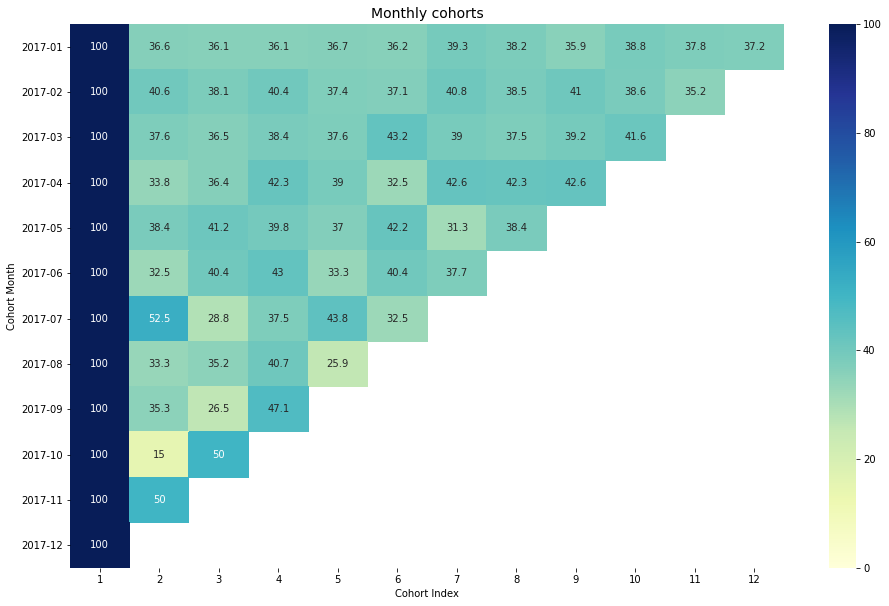

In [48]:
plt.figure(figsize=(16, 10))
plt.title('Monthly cohorts', fontsize=14)
#the 
sns.heatmap(retention, annot=True, vmin=0.0, vmax=100, cmap='YlGnBu', fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()